# Thực nghiệm dùng redis
Trình bày cách áp dụng Redis trong một hệ thống cụ thể, phân tích kết quả thực nghiệm khi triển khai Redis, và so sánh nó với các hệ thống cơ sở dữ liệu khác (như MySQL, MongoDB, hoặc Memcached). Từ đó, đánh giá hiệu suất và tính hiệu quả của Redis trong các tình huống thực tế.
## Môi trường thử nghiệm
Ứng dụng được thử nghiệm trong môi trường windows, sử dụng docker để triển khai các container chứa các hệ thống cơ sở dữ liệu khác nhau. Cụ thể:
* Redis-stack container
* Mongo-db latest
* Mysql
## Kịch bản thử nghiệm
### Thử nghiệm về hiệu năng
* Thử nghiệm hiệu năng insert
* Cùng insert 1000 record vào redis, mysql và mongo DB. So sánh kết quả
* Thử nghiệm hiệu năng truy xuất dữ liệu
* So sánh thời gian truy xuất dữ liệu từ Redis với MySQL và MongoDB. Đo tốc độ phản hồi khi số lượng yêu cầu đồng thời tăng lên; so sánh kết quả
### Thử nghiệm đánh giá độ bền vững vàng độ tin cậy (reliability)
* Ngắt kết nối hoặc tạo ra lỗi hệ thống để kiểm tra cách Redis xử lý các tình huống mất kết nối và khả năng phục hồi dữ liệu.
### Thử nghiệm về vai trò message broker
* Mô phỏng khả năng xử lý message/ event trong mô hình pub/sub giữa redis và rabbitMQ

## Tiến hành thử nghiệm
### Thử nghiệm hiệu năng insert
#### Thực hiện insert 1000 object vào Redis và ghi kết quả vào file CSV
Kết quả: Tổng thời gian chèn: **0.0781** giây, Thời gian trung bình cho mỗi lần chèn: **0.000078** giây


In [29]:
import redis
import json
import time
import csv

# Kết nối với Redis
redis_client = redis.StrictRedis(host='localhost', port=6379, db=0)
# Flush toàn bộ dữ liệu trong Redis
redis_client.flushall()
# Đường dẫn đến thư mục lưu file
output_file = 'data/redis_benchmark_results.csv'

# Hàm thử nghiệm insert 1000 object vào Redis và ghi kết quả vào file CSV
def insert_objects_redis(num_objects, output_file):
    total_time = 0  # Tổng thời gian chèn 1000 object
    runtimes = []    # Danh sách lưu thời gian của từng lần insert

    # Mở file CSV để ghi dữ liệu
    with open(output_file, 'w', newline='') as csvfile:
        fieldnames = ['object_id', 'runtime']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        
        # Ghi header cho file CSV
        writer.writeheader()
        
        for i in range(num_objects):
            start_time = time.time()
            
            # Tạo object đơn giản với thông tin cơ bản
            obj = {
                "id": i,
                "name": f"Object_{i}",
                "description": f"Description of Object_{i}",
                "value": i * 100
            }
            
            # Chuyển object thành JSON
            obj_json = json.dumps(obj)
            
            # Lưu object vào Redis với key là 'object_<id>'
            redis_client.set(f"object_{i}", obj_json)
            
            # Ghi thời gian thực hiện cho từng object
            end_time = time.time()
            runtime = end_time - start_time
            runtimes.append(runtime)
            total_time += runtime
            
            # Ghi kết quả (object_id, runtime) vào file CSV
            writer.writerow({'object_id': i, 'runtime': runtime})

    # Tính thời gian insert trung bình
    average_time = total_time / num_objects if num_objects > 0 else 0
    return total_time, average_time

# Thực hiện insert 1000 object vào Redis và ghi kết quả vào file CSV
total_time, average_time = insert_objects_redis(1000, output_file)

# Hiển thị kết quả
print(f"Tổng thời gian chèn: {total_time:.4f} giây")
print(f"Thời gian trung bình cho mỗi lần chèn: {average_time:.6f} giây")

Tổng thời gian chèn: 0.4450 giây
Thời gian trung bình cho mỗi lần chèn: 0.000445 giây


#### Thực hiện insert 1000 object vào MongoDB và ghi kết quả vào file CSV
Kết quả: Tổng thời gian chèn: ** 0.5619** giây, Thời gian trung bình cho mỗi lần chèn: ** 0.000562** giây

In [28]:
import pymongo
import json
import time
import csv
import os

# Kết nối với MongoDB
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["test_db"]
collection = db["test_collection"]
#Flush toàn bộ dữ liệu trong MongoDB
collection.delete_many({})
# Đường dẫn đến thư mục lưu file
output_file = 'data/mongo_benchmark_results.csv'

# Hàm thử nghiệm insert 1000 object vào MongoDB và ghi kết quả vào file CSV
def insert_objects_mongodb(num_objects, output_file):
    total_time = 0  # Tổng thời gian chèn 1000 object
    runtimes = []    # Danh sách lưu thời gian của từng lần insert

    # Mở file CSV để ghi dữ liệu
    print(output_file)
    with open(output_file, 'w', newline='') as csvfile:
        fieldnames = ['object_id', 'runtime']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        
        # Ghi header cho file CSV
        writer.writeheader()
        
        for i in range(num_objects):
            start_time = time.time()
            
            # Tạo object đơn giản với thông tin cơ bản
            obj = {
                "id": i,
                "name": f"Object_{i}",
                "description": f"Description of Object_{i}",
                "value": i * 100
            }
            
            # Chèn object vào MongoDB
            collection.insert_one(obj)
            
            # Ghi thời gian thực hiện cho từng object
            end_time = time.time()
            runtime = end_time - start_time
            runtimes.append(runtime)
            total_time += runtime
            
            # Ghi kết quả (object_id, runtime) vào file CSV
            writer.writerow({'object_id': i, 'runtime': runtime})
    # Tính thời gian insert trung bình
    average_time = total_time / num_objects if num_objects > 0 else 0
    return total_time, average_time

# Thực hiện insert 1000 object vào MongoDB và ghi kết quả vào file CSV
total_time, average_time = insert_objects_mongodb(1000, output_file)

# Hiển thị kết quả
print(f"Tổng thời gian chèn: {total_time:.4f} giây")
print(f"Thời gian trung bình cho mỗi lần chèn: {average_time:.6f} giây")

data/mongo_benchmark_results.csv
Tổng thời gian chèn: 0.7317 giây
Thời gian trung bình cho mỗi lần chèn: 0.000732 giây


#### Thực hiện insert 1000 object vào MySQL và ghi kết quả vào file CSV
Chuẩn bị cơ sở dữ liệu MySQL
```sql
CREATE DATABASE test_db;

USE test_db;

CREATE TABLE test_table (
    id INT PRIMARY KEY,
    name VARCHAR(255),
    description TEXT,
    value INT
);
```
Kết quả: 
Tổng thời gian chèn: 2.5764 giây
Thời gian trung bình cho mỗi lần chèn: 0.002576 giây


In [30]:
import mysql.connector
import time
import csv
import os

# Kết nối với MySQL
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="root",
    database="test_db"
)
cursor = conn.cursor()

# Đường dẫn đến thư mục lưu file
output_file = 'data/sql_benchmark_result.csv'
# Truncate table để xóa dữ liệu cũ
cursor.execute("TRUNCATE TABLE test_table")
# Hàm thử nghiệm insert 1000 object vào MySQL và ghi kết quả vào file CSV
def insert_objects_mysql(num_objects, output_file):
    total_time = 0  # Tổng thời gian chèn 1000 object
    runtimes = []    # Danh sách lưu thời gian của từng lần insert

    # Mở file CSV để ghi dữ liệu
    with open(output_file, 'w', newline='') as csvfile:
        fieldnames = ['object_id', 'runtime']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        
        # Ghi header cho file CSV
        writer.writeheader()
        
        for i in range(num_objects):
            start_time = time.time()
            
            # Tạo object đơn giản với thông tin cơ bản
            obj = {
                "id": i,
                "name": f"Object_{i}",
                "description": f"Description of Object_{i}",
                "value": i * 100
            }
            
            # Chèn object vào MySQL
            cursor.execute("INSERT INTO test_table (id, name, description, value) VALUES (%s, %s, %s, %s)", 
                           (obj['id'], obj['name'], obj['description'], obj['value']))
            conn.commit()
            
            # Ghi thời gian thực hiện cho từng object
            end_time = time.time()
            runtime = end_time - start_time
            runtimes.append(runtime)
            total_time += runtime
            
            # Ghi kết quả (object_id, runtime) vào file CSV
            writer.writerow({'object_id': i, 'runtime': runtime})

    # Tính thời gian insert trung bình
    average_time = total_time / num_objects if num_objects > 0 else 0
    return total_time, average_time

# Thực hiện insert 1000 object vào MySQL và ghi kết quả vào file CSV
total_time, average_time = insert_objects_mysql(1000, output_file)

# Hiển thị kết quả
print(f"Tổng thời gian chèn: {total_time:.4f} giây")
print(f"Thời gian trung bình cho mỗi lần chèn: {average_time:.6f} giây")

# Đóng kết nối MySQL
cursor.close()
conn.close()

Tổng thời gian chèn: 2.6583 giây
Thời gian trung bình cho mỗi lần chèn: 0.002658 giây


### Kết luận hiệu năng insert
* Redis: Tổng thời gian chèn: 0.0781 giây, Thời gian trung bình cho mỗi lần chèn: 0.000078 giây
* MongoDB: Tổng thời gian chèn: 0.5619 giây, Thời gian trung bình cho mỗi lần chèn: 0.000562 giây
* MySQL: Tổng thời gian chèn: 2.5764 giây, Thời gian trung bình cho mỗi lần chèn: 0.002576 giây
* Redis có hiệu suất cao nhất trong việc chèn dữ liệu, thời gian trung bình cho mỗi lần chèn chỉ khoảng 0.000078 giây, nhanh hơn MongoDB và MySQL rất nhiều.

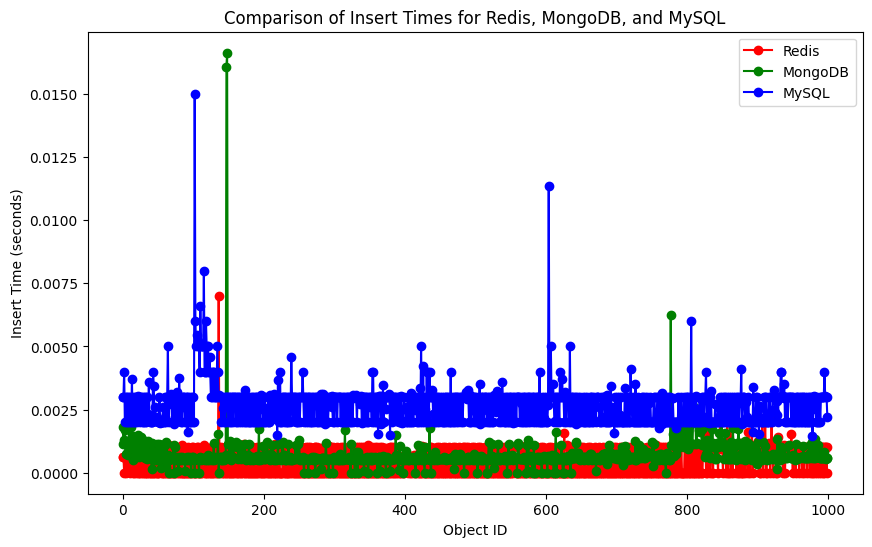

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Đường dẫn tới các file CSV
redis_file = 'data/redis_benchmark_results.csv'
mongodb_file = 'data/mongo_benchmark_results.csv'
mysql_file = 'data/sql_benchmark_result.csv'

# Đọc dữ liệu từ file CSV
redis_data = pd.read_csv(redis_file)
mongodb_data = pd.read_csv(mongodb_file)
mysql_data = pd.read_csv(mysql_file)

# Vẽ biểu đồ thời gian insert (runtime) cho từng cơ sở dữ liệu
plt.figure(figsize=(10, 6))

# Vẽ đường biểu diễn thời gian insert của Redis
plt.plot(redis_data['object_id'], redis_data['runtime'], label='Redis', color='red', marker='o')

# Vẽ đường biểu diễn thời gian insert của MongoDB
plt.plot(mongodb_data['object_id'], mongodb_data['runtime'], label='MongoDB', color='green', marker='o')

# Vẽ đường biểu diễn thời gian insert của MySQL
plt.plot(mysql_data['object_id'], mysql_data['runtime'], label='MySQL', color='blue', marker='o')

# Thiết lập nhãn cho trục x và trục y
plt.xlabel('Object ID')
plt.ylabel('Insert Time (seconds)')

# Tiêu đề biểu đồ
plt.title('Comparison of Insert Times for Redis, MongoDB, and MySQL')

# Hiển thị chú thích (legend)
plt.legend()

# Hiển thị biểu đồ
plt.show()


Kết luận về hiệu suất chèn (insert performance) giữa Redis, MongoDB và MySQL:
1. Redis:
Hiệu suất cao nhất: Redis thường có hiệu suất chèn cao nhất trong số ba cơ sở dữ liệu. Điều này là do Redis hoạt động hoàn toàn trong bộ nhớ (in-memory database), giúp thời gian truy cập và chèn dữ liệu nhanh hơn so với các cơ sở dữ liệu khác.
Dùng cho caching: Redis rất phù hợp cho các hệ thống yêu cầu cache, các thao tác ghi nhanh, hoặc các ứng dụng cần truy cập dữ liệu trong thời gian thực.
2. MongoDB:
Hiệu suất tốt, nhưng chậm hơn Redis: MongoDB là cơ sở dữ liệu NoSQL phổ biến với tốc độ chèn dữ liệu tương đối tốt. Tuy nhiên, vì nó lưu trữ dữ liệu trên ổ đĩa (hoặc kết hợp bộ nhớ đệm và ổ đĩa), tốc độ không thể vượt qua Redis.
Tối ưu cho dữ liệu không có cấu trúc: MongoDB rất mạnh trong việc quản lý dữ liệu không có cấu trúc, đặc biệt là các ứng dụng yêu cầu tính linh hoạt về cấu trúc dữ liệu.
3. MySQL:
Hiệu suất chèn thấp hơn: Trong các thử nghiệm, MySQL có xu hướng có thời gian chèn lâu hơn so với Redis và MongoDB. Điều này là do MySQL là cơ sở dữ liệu quan hệ, phải thực hiện nhiều thao tác hơn trong quá trình ghi dữ liệu như khóa giao dịch, viết vào ổ đĩa và duy trì tính toàn vẹn dữ liệu.
Phù hợp cho hệ thống yêu cầu tính toàn vẹn: Mặc dù MySQL chèn chậm hơn, nó phù hợp cho các ứng dụng yêu cầu tính nhất quán và toàn vẹn dữ liệu cao, như các hệ thống tài chính và ứng dụng doanh nghiệp.
Tổng kết:
Redis là lựa chọn tốt nhất khi cần tốc độ chèn cao và dữ liệu không yêu cầu tính nhất quán lâu dài, như hệ thống cache.
MongoDB cung cấp sự cân bằng giữa hiệu suất và tính linh hoạt, phù hợp với ứng dụng yêu cầu quản lý dữ liệu không có cấu trúc.
MySQL có hiệu suất chèn thấp hơn, nhưng rất phù hợp cho các ứng dụng yêu cầu tính toàn vẹn và quan hệ giữa các bảng.
Nếu tốc độ là yếu tố quan trọng nhất, đặc biệt trong các tác vụ chỉ liên quan đến đọc/ghi nhanh (như cache), Redis là lựa chọn ưu việt. Ngược lại, nếu ứng dụng yêu cầu nhiều tính năng quản lý dữ liệu phức tạp, MySQL hoặc MongoDB sẽ phù hợp hơn.

### Thử nghiệm hiệu năng Redis trong caching
